In [57]:
from jax import grad, vmap, jit
import jax.numpy as np
import matplotlib.pyplot as plt
import numpy as realnp

idea: have two processes (signal + background) with some pre-selection applied, find optimal selection cut that maximizes significance in counting experiment

### generate data and visualize

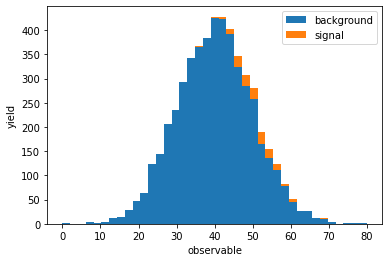

In [58]:
nBg  = 500
nSig = 30
background = realnp.random.normal(40, 10, 5000)
signal = realnp.random.normal(50, 5, 150)

bins = np.linspace(0, 80, 40)

plt.hist([background, signal], bins=bins, stacked=True, label=["background", "signal"])
plt.legend()
plt.xlabel("observable")
plt.ylabel("yield");

### calculate significance for given cut and scan

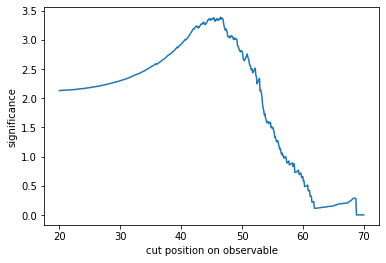

In [181]:
@jit
def significance(S, B):
    return np.sqrt(2*((S+B)*np.log(1+S/B)-S))

def get_significance(cut, S, B):
    S_cut = len(S[S>cut])
    B_cut = len(B[B>cut])
    return significance(S_cut, B_cut)
    

cuts = np.linspace(20, 70, 500)
#cuts = np.linspace(60, 63, 500) #zoom in to see step function behavior
significances = [get_significance(cut, signal, background) for cut in cuts]

plt.plot(cuts, significances)
plt.xlabel("cut position on observable")
plt.ylabel("significance");

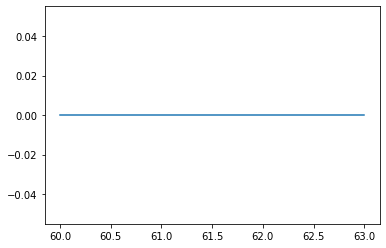

In [171]:
grad_significance = grad(get_significance, argnums=0)
significances_prime = [grad_significance(cut, signal, background) for cut in cuts]
plt.plot(cuts, significances_prime);

this is zero since the significance only changes exactly where events are located, and otherwise is flat...

In [172]:
@jit
def f(x, y):
    return x*y

x = 3.0
y = 4.0
print(grad(f, argnums=0)(x, y)) # df/dx = y
print(grad(f, argnums=1)(x, y)) # df/dy = x
print(f(x, y))

4.0
3.0
12.0


### alternative approach
give events weights, `1` in the limit where they are far above the cut, and `0` if far below, with adjustable steepness

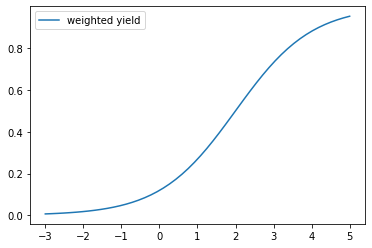

In [201]:
@jit
def yield_after_cut(x, c):
    steepness = 1 # too large -> NaNs later on...
    passed = 1/(1+np.exp(-steepness*(x-c)))
    #failed = 1-passed
    #return passed, failed
    return passed

#x = np.linspace(-3,3,500)

x = np.linspace(-3, 5, 50)
#y_pass, y_fail = yield_after_cut(x, 1.25)
TEST_CUT = 2
y_pass = yield_after_cut(x, TEST_CUT)

#assert np.allclose(y_pass + y_fail, np.ones_like(x))

plt.plot(x, y_pass, label="weighted yield")
plt.legend();

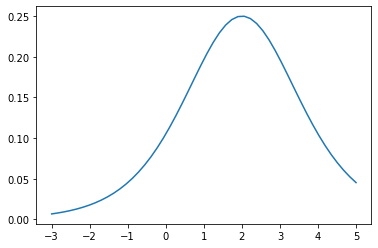

In [202]:
yield_prime = grad(yield_after_cut, argnums=0)
y_pass_prime = [yield_prime(x_entry, TEST_CUT) for x_entry in x]
#print(y_pass_prime)
plt.plot(x, y_pass_prime)

max significance at cut 45.1503


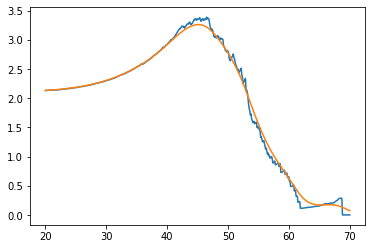

In [212]:
@jit
def significance(S, B):
    return np.sqrt(2*((S+B)*np.log(1+S/B)-S))

@jit
def get_significance_BETTER(cut, S, B):
    S_pass = yield_after_cut(S, cut)
    B_pass = yield_after_cut(B, cut)
    sum_S_weighted = np.sum(S_pass)
    sum_B_weighted = np.sum(B_pass)
    return significance(sum_S_weighted, sum_B_weighted)

cuts_BETTER = np.linspace(20, 70, 500)
#cuts_BETTER = np.linspace(60, 63, 50)
significances_BETTER = np.asarray([get_significance_BETTER(cut, signal, background) for cut in cuts_BETTER])

plt.plot(cuts, significances, label="discrete")
plt.plot(cuts_BETTER, significances_BETTER, label="smooth");

print("max significance at cut", cuts_BETTER[np.argmax(significances_BETTER)])

intercepts at [45.1503  65.29058 66.69339]


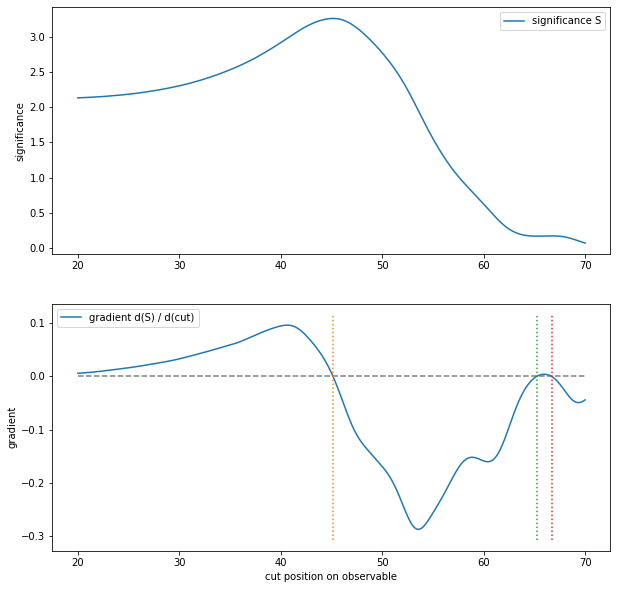

In [242]:
from jax.config import config
config.update("jax_debug_nans", True)

sig_gradient_function = grad(get_significance_BETTER, argnums=0)
sig_prime_BETTER = np.asarray([sig_gradient_function(cut, signal, background) for cut in cuts_BETTER])


# draw significance again
_ = plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(cuts_BETTER, significances_BETTER, label="significance S")
plt.ylabel("significance")
plt.legend();


# add gradient
plt.subplot(2,1,2)
plt.plot([20, 70], [0,0], '--', c='grey')
plt.plot(cuts_BETTER, sig_prime_BETTER, label='gradient d(S) / d(cut)');

def get_intercept_indices(arr):
    intercepts = []
    for i in range(len(arr)):
        # check if sign changed, meaning zero was crossed
        if arr[i]*arr[i+1] < 0:
            # pick side closer to zero and return index
            if np.abs(arr[i]) > np.abs(arr[i+1]):
                intercepts.append(i+1)
            else:
                intercepts.append(i)
    return np.asarray(intercepts)
            
intercepts = get_intercept_indices(sig_prime_BETTER)
cut_values = np.asarray([cuts_BETTER[intercept] for intercept in intercepts])

print("intercepts at", cut_values)

xmin, xmax, ymin, ymax = plt.axis()

for cval in cut_values:
    plt.plot([cval, cval], [ymin, ymax], ':')
plt.xlabel("cut position on observable")
plt.ylabel("gradient")
plt.legend();

now write a simple gradient ascent function to efficiently find the maximum significance

pos is 55.0 grad is -0.25672776
pos is 45.149643 grad is -4.567206e-06
pos is 45.149544 grad is -4.5076013e-07
pos is 45.149544 grad is -4.5076013e-07


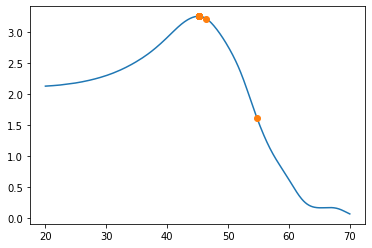

In [259]:
steps = 1000

c0 = 55.0 # initial position
alpha = 1.0 # step size

steps_taken = []

for i in range(steps):
    # reduce step size after a while
    if i%1000 == 0 and i != 0:
        alpha = alpha/10
        print("new alpha is", alpha)
    grad_at_pos = sig_gradient_function(c0, signal, background)
    if i%250 == 0:
        print("pos is", c0, "grad is", grad_at_pos)
    c0 = c0 + alpha*grad_at_pos
    if i%50 == 0:
        steps_taken.append(c0)
        
sig_at_steps = np.asarray([get_significance_BETTER(step, signal, background) for step in steps_taken])

plt.plot(cuts_BETTER, significances_BETTER, label="significance")
plt.plot(steps_taken, sig_at_steps, 'o', label ="steps")